##Dependancies

In [1]:
# Install and import libraries
%%capture
!pip install rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdChemReactions
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import MolStandardize, inchi
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import RDLogger

!pip install matplotlib
import matplotlib.pyplot as plt

from concurrent.futures import ThreadPoolExecutor, TimeoutError

import numpy as np

from dataclasses import dataclass
from typing import List
from typing import Tuple

from IPython.display import display
from IPython.display import Image

##Individual Standardize Functions

In [2]:
def normalize_molecule(mol):
    """
    Normalize a molecule using RDKit's Normalizer.
    Create a normalizer object, then normalize the molecule

    Parameters:
    mol (rdkit.Chem.Mol): The molecule to normalize.

    Returns:
    rdkit.Chem.Mol: The normalized molecule.
    """
    normalizer = rdMolStandardize.Normalizer()
    normalized_mol = normalizer.normalize(mol)

    return normalized_mol

def remove_small_fragments(mol):
    """
    Remove small fragments from a molecule, keeping only the largest fragment.
    Create a LargestFragmentChooser object, then select the largest fragment

    Parameters:
    mol (rdkit.Chem.Mol): The molecule from which to remove small fragments.

    Returns:
    rdkit.Chem.Mol: The molecule with only the largest fragment remaining.
    """
    fragment_parent = MolStandardize.fragment.LargestFragmentChooser()
    largest_fragment= fragment_parent.choose(mol)
    return largest_fragment

def neutralize_charges(mol):
    """
    Neutralize charges in a molecule using RDKit's Uncharger.
    Create an Uncharger object, then apply the uncharger to neutralize the molecule

    Parameters:
    mol (rdkit.Chem.Mol): The molecule to neutralize.

    Returns:
    rdkit.Chem.Mol: The neutralized molecule.
    """
    uncharger = rdMolStandardize.Uncharger()
    neutralized_mol = uncharger.uncharge(mol)

    return neutralized_mol

def standardize_aromatization(mol):
    """
    Standardize the aromatization state of a molecule.
    Kekulize the molecule, if possible, to define explicit bonds
    If kekulization fails (e.g., for some aromatic systems), catch the exception
      and no action is needed. The molecule remains unchanged

    Parameters:
    mol (rdkit.Chem.Mol): The molecule to standardize.

    Returns:
    rdkit.Chem.Mol: The molecule with a standardized aromatization state.
    """

    try:
        Chem.Kekulize(mol, clearAromaticFlags=True)
    except:
        pass

    # Set aromaticity flags based on RDKit's model
    Chem.SetAromaticity(mol, Chem.AromaticityModel.AROMATICITY_MDL)

    return mol

def standardize_tautomerization(mol):
    """
    Standardize tautomerization of a molecule.
    Create a tautomer enumerator, then get the canonical tautomer

    Parameters:
    mol (rdkit.Chem.Mol): The molecule to standardize.

    Returns:
    rdkit.Chem.Mol: The standardized (canonical) tautomer.
    """
    enumerator = rdMolStandardize.TautomerEnumerator()
    canonical_tautomer = enumerator.Canonicalize(mol)

    return canonical_tautomer

def standardize_tautomerization_with_timeout(mol, timeout=10):
    """
    Attempt to standardize tautomerization with a specified timeout.
    Returns the standardized molecule or None if a timeout/error occurs.
    """
    try:
        with ThreadPoolExecutor(max_workers=1) as executor:
            future = executor.submit(standardize_tautomerization, mol)
            return future.result(timeout=timeout)  # Timeout specified in seconds
    except Exception as e:
        # Catch both TimeoutError and any other exceptions
        return None

def apply_smirks_transformation(mol, smirks):
    """
    Attempt to apply a SMIRKS transformation to a molecule.
    If the transformation is applicable, return the first product.
    If not, return the original molecule.
    """
    reaction_operator = rdChemReactions.ReactionFromSmarts(smirks)
    products = reaction_operator.RunReactants((mol,))

    if products:
        # Assuming the first product of the first set is the desired outcome
        first_product_set = products[0]
        if first_product_set:
            return first_product_set[0]

    # If no products or transformation not applicable, return original molecule
    return mol

##Combined STD Function

Note: You will notice that this function returns two InChIs: a final_inchi and an intermediate_inchi. The reason for the intermediate_inchi is because I originally struggled placing the standardization order so that the tautomerization worked correctly or that the code would work to completion (sometimes the code ran to infinity in the early stages). To troubleshoot, I moved around the intermediate_inchi to see what the moleucle looked like at what stage in the process. If you come across a molecule that isn't standardizing properly, moving around the intermediate_inchi might identify the bottleneck/problem step. Or it can eventually be removed, but the subsequent code usage would need to change to only return one final standardized InChI.

In [50]:
# Initialize an RDKit logger
rd_logger = RDLogger.logger()
rd_logger.setLevel(RDLogger.CRITICAL)  # Set the logger level to CRITICAL to capture errors

#Code provided to standardize the inchi
error_count = 0  # Initialize an error counter

tautomerization_failures = []

def std(inchi, return_intermediate=False):
    global error_count, tautomerization_failures
    intermediate_inchi = None
    final_inchi = None

    try:

      # assert isinstance(inchi, str), "InChI must be a string"
      mol = Chem.MolFromInchi(str(inchi))

      # if Inchi is deemed invalid
      if mol is None:
          error_count += 1
          return (None, None) if return_intermediate else None


      #Add hydrogens
      #mol = Chem.AddHs(mol)

      #Normalize by conducting a series of normalization transformations
      mol = normalize_molecule(mol)

      # Remove small fragments, keeping the largest one
      mol = remove_small_fragments(mol)

      # Neutralize charges
      mol = neutralize_charges(mol)

      #Standardize aromatization state
      mol = standardize_aromatization(mol)

      #Conversion of cyclical pyranose and furanose sugars to open-chain form
      mol = Chem.AddHs(mol)
      smirks_pyranose = '[C:1]1-[C:2]-[C:3]-[C:4]-[C:5](-[O:6]-[H])-[O:7]-1>>[O:7](-[H])-[C:1]-[C:2]-[C:3]-[C:4]-[C:5]=[O:6]'
      smirks_furanose = '[C:1]1-[C:2]-[C:3]-[C:5](-[O:6]-[H])-[O:7]-1>>[O:7](-[H])-[C:1]-[C:2]-[C:3]-[C:5]=[O:6]'
      mol = apply_smirks_transformation(mol, smirks_pyranose)
      mol = apply_smirks_transformation(mol, smirks_furanose)

      # Convert back to InChI to capture the state right before tautomerization
      intermediate_inchi = Chem.MolToInchi(mol)

      # Standardize tautomerization with a timeout mechanism
      mol = standardize_tautomerization_with_timeout(mol)
      if mol is None:
          # Log the InChI of the compound that failed tautomerization
          tautomerization_failures.append((inchi, intermediate_inchi))
          error_count += 1
          return (None, intermediate_inchi) if return_intermediate else None

      # Convert the final molecule back to InChI
      final_inchi = Chem.MolToInchi(mol)
      return (final_inchi, intermediate_inchi) if return_intermediate else final_inchi


    except Exception as e:
      error_count += 1
      rd_logger.error(f"Error processing InChI: {inchi} - {e}")
      return (None, None) if return_intermediate else None


##Conduct Standardization and Visualize

In [19]:
def std_and_visualize(inchi):
    """
    Print the original and standardized InChI, and visualize the molecule before and after standardization.

    Parameters:
    inchi (str): The InChI string of the molecule to standardize and visualize.
    """
    # Convert the InChI string to an RDKit molecule
    mol = Chem.MolFromInchi(inchi)
    if not mol:
        raise ValueError("Could not convert InChI to molecule.")

    # Standardize the molecule and get both the final and intermediate InChI
    standardized_inchi, intermediate_inchi = std(inchi, return_intermediate=True)
    standardized_mol = Chem.MolFromInchi(standardized_inchi) if standardized_inchi else None

    # Visualize the original and standardized molecules
    original_vs_standardized = [mol, standardized_mol]
    img = Draw.MolsToGridImage(original_vs_standardized, useSVG=True, legends=['Original', 'Standardized'], subImgSize=(350, 350))

    # Print the original and standardized InChI
    print("OLD InChI:", inchi)
    print("NEW InChI:", standardized_inchi)

    return img


OLD InChI: InChI=1S/C15H22N6O5S/c1-27(3-2-7(16)15(24)25)4-8-10(22)11(23)14(26-8)21-6-20-9-12(17)18-5-19-13(9)21/h5-8,10-11,14,22-23H,2-4,16H2,1H3,(H2-,17,18,19,24,25)/p+1/t7-,8+,10+,11+,14+,27-/m0/s1
NEW InChI: InChI=1S/C15H22N6O5S/c1-27(3-2-7(16)15(24)25)4-8-10(22)11(23)14(26-8)21-6-20-9-12(17)18-5-19-13(9)21/h5-8,10-11,14,22-23H,2-4,16H2,1H3,(H2-,17,18,19,24,25)/p+1/t7?,8-,10-,11-,14-,27+/m1/s1


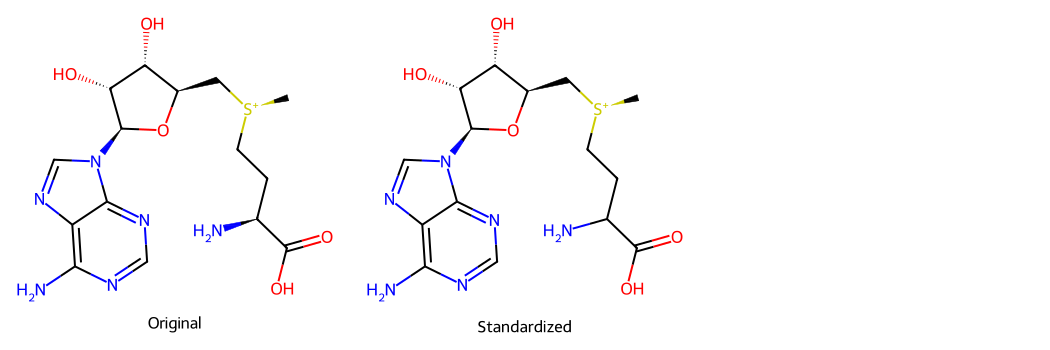

In [35]:
#std_and_visualize usage!
inchi = "InChI=1S/C15H22N6O5S/c1-27(3-2-7(16)15(24)25)4-8-10(22)11(23)14(26-8)21-6-20-9-12(17)18-5-19-13(9)21/h5-8,10-11,14,22-23H,2-4,16H2,1H3,(H2-,17,18,19,24,25)/p+1/t7-,8+,10+,11+,14+,27-/m0/s1"
img = std_and_visualize(inchi)
img

## Test Single Standardization Function

Test only one function from the entire STD function. Copy and paste from these listed below:
*   normalize_molecule
*   remove_small_fragments
*   neutralize_charges
*   standardize_aromatization
*   standardize_tautomerization
*   standardize_tautomerization_with_timeout
*   apply_smirks_transformation

In [28]:
def single_std_and_visualize(inchi, standardization_func):
    """
    Visualize the molecule before and after applying a specified standardization function.

    Parameters:
    inchi (str): The InChI string of the molecule to standardize and visualize.
    standardization_func (function): The standardization function to apply to the molecule.
    """
    # Convert the InChI string to an RDKit molecule
    mol = Chem.MolFromInchi(inchi)
    if not mol:
        raise ValueError("Could not convert InChI to molecule.")

    # Apply the specified standardization function
    standardized_mol = standardization_func(mol)
    if not standardized_mol:
        raise ValueError("Standardization function failed to process molecule.")

    # Convert standardized molecule back to InChI, handling None case
    standardized_inchi = Chem.MolToInchi(standardized_mol) if standardized_mol else "Standardization failed"

    # Visualize the original and standardized molecules
    original_vs_standardized = [mol, standardized_mol]
    img = Draw.MolsToGridImage(original_vs_standardized, useSVG=True, legends=['Original', 'Standardized'], subImgSize=(300, 300))

    # Print the original and standardized InChI
    print("Function tested:", standardization_func)
    print("OLD InChI:", inchi)
    print("NEW InChI:", standardized_inchi)

    return img

Function tested: <function standardize_aromatization at 0x7d3bce17d480>
OLD InChI: InChI=1S/C19H23N7O5/c20-19-25-15-14(17(29)26-19)23-12(9-22-15)8-21-11-5-3-10(4-6-11)16(28)24-13(18(30)31)2-1-7-27/h3-7,12-13,21,23H,1-2,8-9H2,(H,24,28)(H,30,31)(H4,20,22,25,26,29)/p-1/t12-,13-/m0/s1
NEW InChI: InChI=1S/C19H23N7O5/c20-19-25-15-14(17(29)26-19)23-12(9-22-15)8-21-11-5-3-10(4-6-11)16(28)24-13(18(30)31)2-1-7-27/h3-7,12-13,21,23H,1-2,8-9H2,(H,24,28)(H,30,31)(H4,20,22,25,26,29)/p-1/t12-,13-/m0/s1


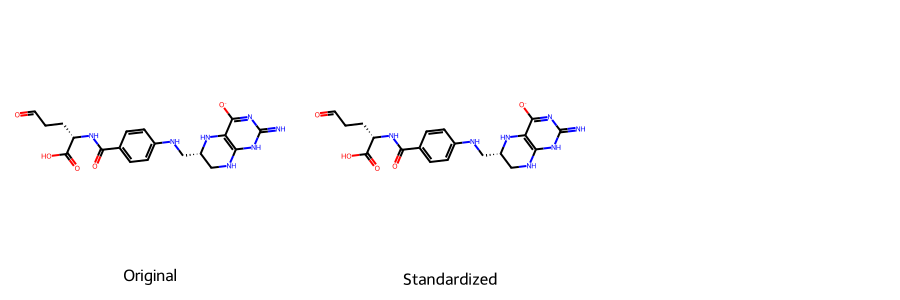

In [29]:
# single_std_and_visualize usage:
inchi = "InChI=1S/C19H23N7O5/c20-19-25-15-14(17(29)26-19)23-12(9-22-15)8-21-11-5-3-10(4-6-11)16(28)24-13(18(30)31)2-1-7-27/h3-7,12-13,21,23H,1-2,8-9H2,(H,24,28)(H,30,31)(H4,20,22,25,26,29)/p-1/t12-,13-/m0/s1"
standardization_func = standardize_aromatization

img = single_std_and_visualize(inchi, standardization_func)
img


## Compare Two Molecules

This code allows for the comparrison of two molecules at the same time to see if they condense down to the same InChI after standardization.

In [48]:
def dual_std_and_visualize(inchi1, inchi2):
    """
    Print the original and standardized InChI for two molecules, and visualize both molecules before and after standardization.

    Parameters:
    inchi1 (str): The first InChI string of the molecule to standardize and visualize.
    inchi2 (str): The second InChI string of the molecule to standardize and visualize.
    """
    # Convert the first InChI string to an RDKit molecule
    mol1 = Chem.MolFromInchi(inchi1)
    if not mol1:
        raise ValueError("Could not convert the first InChI to a molecule.")

    # Convert the second InChI string to an RDKit molecule
    mol2 = Chem.MolFromInchi(inchi2)
    if not mol2:
        raise ValueError("Could not convert the second InChI to a molecule.")

    # Standardize the first molecule and get both the final and intermediate InChI
    standardized_inchi1, intermediate_inchi1 = std(inchi1, return_intermediate=True)
    standardized_mol1 = Chem.MolFromInchi(standardized_inchi1) if standardized_inchi1 else None

    # Standardize the second molecule and get both the final and intermediate InChI
    standardized_inchi2, intermediate_inchi2 = std(inchi2, return_intermediate=True)
    standardized_mol2 = Chem.MolFromInchi(standardized_inchi2) if standardized_inchi2 else None

    # Visualize the original and standardized molecules for both inputs
    original_vs_standardized_1 = [mol1, standardized_mol1]
    original_vs_standardized_2 = [mol2, standardized_mol2]
    img1 = Draw.MolsToGridImage(original_vs_standardized_1, useSVG=True, legends=['Original 1', 'Standardized 1'], subImgSize=(350, 350))
    img2 = Draw.MolsToGridImage(original_vs_standardized_2, useSVG=True, legends=['Original 2', 'Standardized 2'], subImgSize=(350, 350))

    # Print the original and standardized InChI for both molecules
    print("OLD InChI 1:", inchi1)
    print("OLD InChI 2:", inchi2)
    print("NEW InChI 1:", standardized_inchi1)
    print("NEW InChI 2:", standardized_inchi2)

    return img1, img2


OLD InChI 1: InChI=1S/C5H10N2O3/c6-3(5(9)10)1-2-4(7)8/h3H,1-2,6H2,(H2,7,8)(H,9,10)/t3-/m0/s1
OLD InChI 2: InChI=1S/C5H10N2O3/c6-3(5(9)10)1-2-4(7)8/h3H,1-2,6H2,(H2,7,8)(H,9,10)/t3-/m1/s1
NEW InChI 1: InChI=1S/C5H11N2O3/c6-3(5(9)10)1-2-4(7)8/h3,8H,1-2,6-7H2,(H,9,10)
NEW InChI 2: InChI=1S/C5H11N2O3/c6-3(5(9)10)1-2-4(7)8/h3,8H,1-2,6-7H2,(H,9,10)


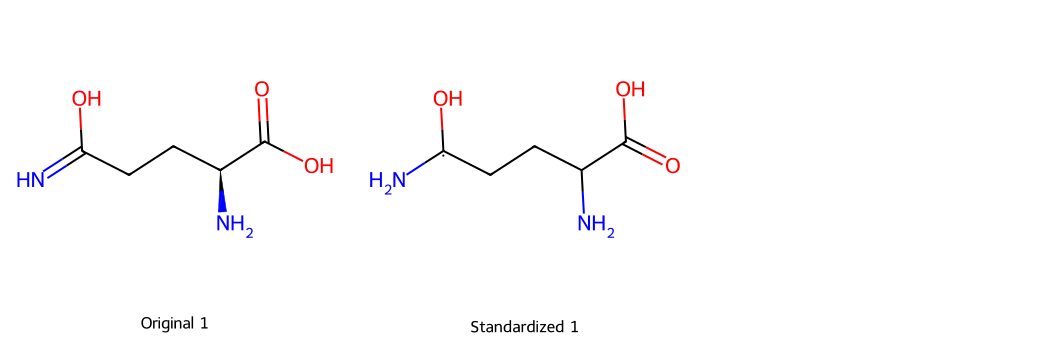

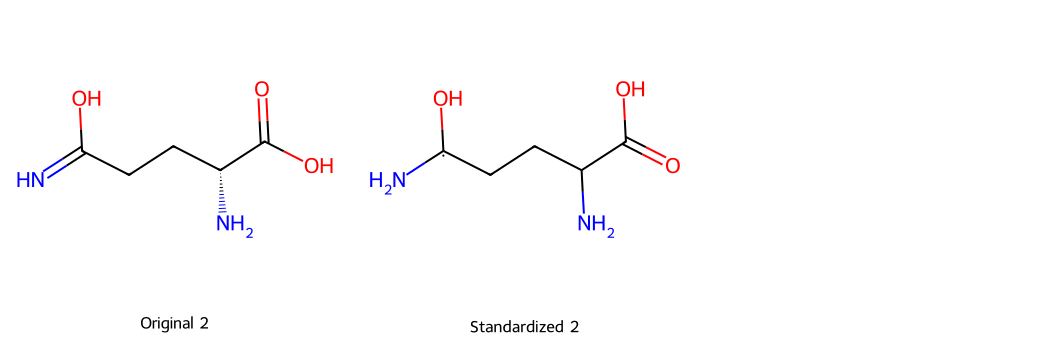

In [51]:
# Dual usage!
inchi1 = "InChI=1S/C5H10N2O3/c6-3(5(9)10)1-2-4(7)8/h3H,1-2,6H2,(H2,7,8)(H,9,10)/t3-/m0/s1"
inchi2 = "InChI=1S/C5H10N2O3/c6-3(5(9)10)1-2-4(7)8/h3H,1-2,6H2,(H2,7,8)(H,9,10)/t3-/m1/s1"
img1, img2 = dual_std_and_visualize(inchi1, inchi2)
display(img1)
display(img2)